In [2]:
%run ../../utils/helper.ipynb
import itertools
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
})
plt.style.use("science")

In [3]:
project_dir = "/work/clas12/users/gmat/clas12/clas12_dihadrons/projects"
project_name = "ana_v3_RGB"

In [4]:
create_asym_yaml(project_dir,project_name)

In [5]:
data = get_asym_yaml(project_dir,project_name)

In [11]:
# LOAD RGB and RGA and merged

# Load the first YAML file
with open('../../projects/ana_v2/dihadron_binning.yaml') as f:
    data1 = yaml.safe_load(f)

# Load the second YAML file
with open('../../projects/ana_v3_RGB/dihadron_binning.yaml') as f:
    data2 = yaml.safe_load(f)

# Merge the two dictionaries
data_merged = {**data1, **data2}

# Save the merged data to a new YAML file
with open('RGA_RGB_merged.yaml', 'w') as f:
    yaml.dump(data_merged, f)
    

In [12]:
# Load the merged YAML file into a Python dictionary
with open('RGA_RGB_merged.yaml') as f:
    data = yaml.safe_load(f)


In [197]:
def plot_channels(data, channels, drop_edges=False):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]
    
    num_plots = 7

    fig, axs = plt.subplots(1, num_plots+1, figsize=(2*(num_plots+1), 2), dpi=150, sharey=True, sharex=True, gridspec_kw={'wspace': 0, 'width_ratios': [1]*num_plots + [2]})
    
    # Calculate the center of the first 7 plots
    total_width = num_plots + 1  # The total width ratios of the 7 plots plus the legend subplot
    center_x = num_plots / (2 * total_width)  # Calculate the center x position of the 7 plots

    # Set the suptitle with the calculated center_x position
    fig.suptitle('My Plot Title', fontsize=16, y=1.1, x=center_x)

    for j, channel in enumerate(channels):
        headers = channel
        VERSION = headers[0].replace("Fall2018_RGA_inbending","inb. f18 rg-a").replace("Fall2018_RGA_outbending","outb. f18 rg-a").replace("Spring2019_RGA_inbending","inb. sp19 rg-a").replace("MC_RGA_inbending","inb. MC rg-a").replace("MC_RGA_outbending","outb. MC rg-a")
        CHANNEL = headers[2].replace("piplus", "$\pi^{+}$").replace("piminus", "$\pi^{-}$").replace("pi0", "$\pi^{0}$").replace("_", "")

        # If a specific plot has a duplicate channel (i.e. dihadron pair) then flag by their version
        dihadron_pairs = [c[2] for c in channels]
        #if(dihadron_pairs.count(headers[2])>1):
        CHANNEL+=f" ({VERSION})"

        if("_sig" in headers[6]):
            CHANNEL+=" sig"
        elif("_bg" in headers[6]):
            CHANNEL+=" bkg"
        for i in range(num_plots):
            x, y, yerr = get_data_from_yaml(data, headers, get_modulations(2)[0][i])
            if(drop_edges==True):
                x=x[1:-1]
                y=y[1:-1]
                yerr=yerr[1:-1]
            axs[i].errorbar(x, y, yerr=yerr, fmt="o", color=colors[j], markersize=3, capsize=1, label=r"{}".format(CHANNEL))
            axs[i].set_title(r"${}$".format(get_modulations(2)[1][i]))
            if("MC" in headers[0]):
                sfunc,bfunc=get_inject_func("/work/clas12/users/gmat/clas12/clas12_dihadrons/utils/binning_files/Binning_1d_only.yaml",f"{headers[3]}_binned")
                func=(sfunc[i] if "_sig" in headers[6] else bfunc[i])

                x_inject, y_inject = get_inject_plot(func,xmin=np.amin(x),xmax=np.amax(x))
                axs[i].plot(x_inject,y_inject,color=colors[j],linestyle="dashed",linewidth=1)
            axs[i].axhline(y=0, color='black', linestyle='--')
            axs[i].legend(borderpad=1, labelspacing=1, handlelength=0.8, handletextpad=0.5, loc='upper left')
            axs[i].grid(True)
            xlabel=headers[3].replace("Mh","$M_{h}[GeV]$")
            axs[i].set_xlabel(r"{}".format(xlabel))
        # Remove y tick labels for all but the first subplot

        for i in range(1, num_plots+1):
            axs[i].tick_params(axis='y', which='both', labelleft=False)
        ax = axs[0]
        ax.set_ylabel(r"$A_{LU}$")
        ymax = np.amax(np.abs(ax.get_ylim()))
        ax.set_ylim(-ymax,ymax)

        # Create an extra subplot for the legend only
        handles, labels = axs[0].get_legend_handles_labels()
        legend = axs[-1].legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.15))

        # Move the legend down a little bit
        legend.set_bbox_to_anchor((0.5, 0.9))
        axs[-1].text(0.5, 0.92, 'Key', ha='center', transform=axs[-1].transAxes)

        # Remove axis and grid from legend subplot
        axs[-1].axis('off')
        axs[-1].grid(False)
        
        # Remove legends from all other subplots
        for i in range(0, num_plots):
            axs[i].legend().remove()

In [21]:
def get_color_from_channel(channel,colors):
    dihadron_pair=channel[2]
    #colors=["gold","blue","orangered","maroon","green","black"]
    if(dihadron_pair=="piplus_pi0"):
        return colors[0]
    elif(dihadron_pair=="piminus_pi0"):
        return colors[1]
    elif(dihadron_pair=="piplus_piminus"):
        return colors[2]
    elif(dihadron_pair=="piplus_piplus"):
        return colors[3]
    elif(dihadron_pair=="piminus_piminus"):
        return colors[4]
    elif(dihadron_pair=="pi0_pi0"):
        return colors[5]
    else:
        return colors[0]
    
def get_markerstyle_from_channel(channel):
    dihadron_pair=channel[2]
    machine_learning=channel[4]
    if(not "pi0" in dihadron_pair):
        return "o"
    elif(machine_learning=="ML"):
        return "^"
    else:
        return "v"
    
def plot_channels(data, channels, drop_edges=False, my_list=None, out_plot=None, extra_legends=None, y_lim=None, custom_legends=None):
    num_plots = 7
    
    # Set up the figure and subplots
    if my_list is None:
        my_list = list(range(num_plots))

        
    fig, axs = plt.subplots(1, len(my_list)+1, figsize=(2*(len(my_list)+1.5), 2), dpi=150, sharey=True, sharex=True, gridspec_kw={'wspace': 0.1, 'width_ratios': [(1 if len(my_list)>1 else 1.5)]*len(my_list) + [2]})
    #fig.suptitle('My Plot Title', fontsize=16, y=1.1, x=len(my_list) / (2 * (len(my_list) + 1)))
    
    for j, channel in enumerate(channels):
        channel = channels[j]
        channel_label = format_channel_label(channel,channels)
        extra_legend = ("" if extra_legends==None else extra_legends[j])
        custom_legend = ("" if custom_legends==None else custom_legends[j])
        plot_data(data, axs, channel, channel_label, j, channels, my_list, drop_edges, extra_legend, custom_legend)
    
    format_subplots(axs, len(my_list))
    create_legend_subplot(axs, len(my_list))
    
    if(y_lim!=None):
        axs[0].set_ylim(y_lim[0],y_lim[1])
        
    if(out_plot!=None):
        plt.savefig(out_plot)
        plt.close()
    
def dup_items(items, channels):
    if(type(items)!=list):
        items=[items]
    
    occurences = 0
    for channel in channels:
        all_found=True
        for item in items:
            if(not item in channel):
                all_found=False
        if(all_found):
            occurences+=1
    if(occurences>1):
        return True
    else:
        return False

def format_dihadron_label(dihadron_pair):
    return dihadron_pair.replace("piplus", "$\pi^{+}$").replace("piminus", "$\pi^{-}$").replace("pi0", "$\pi^{0}$").replace("_", "")

def format_channel_label(channel,channels):
    headers = channel
    version = headers[0]
    dihadron_pair = headers[2]
    machine_learning = headers[4]
    
    version = version.replace("Fall2018_RGA_inbending","inb. f18 rg-a").replace("Fall2018_RGA_outbending","outb. f18 rg-a").replace("Spring2019_RGA_inbending","inb. sp19 rg-a").replace("MC_RGA_inbending","inb. MC rg-a").replace("MC_RGA_outbending","outb. MC rg-a")
    version = version.replace("Spring2020_RGB_inbending","inb. sp20 rg-b").replace("Fall2019_RGB_outbending","outb. f19 rg-b").replace("Spring2019_RGB_inbending","inb. sp19 rg-b").replace("MC_RGB_inbending","inb. MC rg-b").replace("MC_RGB_outbending","outb. MC rg-b")
    plot_label = format_dihadron_label(dihadron_pair)
    
    if "pi0" in dihadron_pair:
        plot_label += (" ML" if machine_learning=="ML" else " Trad.")
        
    #if dup_items(dihadron_pair,channels):
    plot_label += f" ({version})"
        
    if "splot_sig" in headers[6]:
        plot_label += " sPlot sig"
    elif "splot_bg" in headers[6]:
        plot_label += " sPlot bkg"
    elif "sideband" in headers[6]:
        plot_label += " sideband sig"
    return plot_label

def plot_data(data, axs, channel, channel_label, channel_index, channels, my_list, drop_edges, extra_legend, custom_legend):
    dihadron_pair = channel[2]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:6]
    # Set color for the plot based on the dihadron pair and channel index
    if(dup_items(dihadron_pair,channels)):
        color = colors[channel_index]
    else:
        color = get_color_from_channel(channel,colors)
    # Get the marker style for the plot based on the channel
    markerstyle = get_markerstyle_from_channel(channel)
    
    # Store plot arguments in a dictionary
    plot_kwargs = {
        'fmt': markerstyle,
        'color': color,
        'markersize': 3,
        'capsize': 1.2,
        'label': r"{} {}".format(channel_label, extra_legend)
    }
    
    if channel[6] == "sideband":
        plot_kwargs['markerfacecolor'] = 'white'
    
    if custom_legend:
        plot_kwargs['label'] = format_dihadron_label(custom_legend)
    
    for ix_axis,i in enumerate(my_list):
        # Get data for the plot
        x, y, yerr = get_data_from_yaml(data, channel, get_modulations(2)[0][i])
        # If drop_edges is True, remove the first and last elements of x, y, and yerr
        if drop_edges:
            x, y, yerr = x[1:-1], y[1:-1], yerr[1:-1]

        # Plot the data with the given arguments
        axs[ix_axis].errorbar(x, y, yerr=yerr, **plot_kwargs)
        axs[ix_axis].set_title(r"${}$".format(get_modulations(2)[1][i]))

        # If the channel is MC, plot the injection function
        if "MC" in channel[0]:
            sfunc, bfunc = get_inject_func("/work/clas12/users/gmat/clas12/clas12_dihadrons/utils/binning_files/Binning_1d_only.yaml", f"{channel[3]}_binned")
            func = sfunc[i] if ("_sig" in channel[6] or not "pi0" in channel[2]) else bfunc[i]
            x_inject, y_inject = get_inject_plot(func, xmin=np.amin(x), xmax=np.amax(x))
            axs[ix_axis].plot(x_inject, y_inject, color=color, linestyle="dashed", linewidth=1,label=r"{} inject".format(format_dihadron_label(channel[2])))
            
        # Add horizontal dashed line at y=0
        axs[ix_axis].axhline(y=0, color='black', linestyle='--')
        # Turn on the grid
        axs[ix_axis].grid(True)
        # Set the x-axis label based on the channel
        xlabel = channel[3].replace("Mh", "$M_{h}[GeV]$")
        axs[ix_axis].set_xlabel(r"{}".format(xlabel))
        
def format_subplots(axs, num_plots):
    axs[0].set_ylabel(r"$A_{LU}$")
    ymax = np.amax(np.abs(axs[0].get_ylim()))
    axs[0].set_ylim(-ymax, ymax)
    axs[0].set_xlim(axs[0].get_xlim()[0]-0.1,axs[0].get_xlim()[1]+0.1)
    for i in range(1, num_plots+1):
        axs[i].tick_params(axis='y', which='both', labelleft=False)

def create_legend_subplot(axs, num_plots):
    handles, labels = axs[0].get_legend_handles_labels()
    legend = axs[-1].legend(handles, labels, loc='upper center', ncol=1, bbox_to_anchor=(0.5, -0.15),fontsize=20)
    legend.set_bbox_to_anchor((0.5, 0.9))
    axs[-1].text(0.5, 0.92, 'Key', ha='center', transform=axs[-1].transAxes)
    axs[-1].axis('off')
    axs[-1].grid(False)

    for i in range(0, num_plots):
        axs[i].legend().remove()

# Compare RG-A RG-B
---

In [ ]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
ML=["noML","ML","noML","ML","noML"]
cuts=["cut_v6","cut_v4","cut_v3","cut_v7","cut_v6"]
channels_RGA=["Fall2018_RGA_inbending","Fall2018_RGA_inbending","Fall2018_RGA_inbending","Fall2018_RGA_outbending","Fall2018_RGA_outbending"]
channels_RGB=["Spring2019_RGB_inbending","Spring2019_RGB_inbending","Spring2019_RGB_inbending","Fall2019_RGB_outbending","Fall2019_RGB_outbending"]

for binvar in binvars:
    for channel,flag,ml,cut,channel_RGA,channel_RGB in zip(channels,flags,ML,cuts,channels_RGA,channels_RGB):  
        plot_channels(data,[[channel_RGA,cut,channel,binvar,ml,"AZI",flag],
                            [channel_RGB,cut,channel,binvar,ml,"AZI",flag]],
                      drop_edges=True,
                      out_plot=f"{project_dir}/{project_name}/plots/asym/RGA_RGB_with_cuts_{binvar}_{channel}.png",
                      my_list = [1,2,3,5],
                      custom_legends = [f"{channel} RG-A", f"{channel} RG-B"])

# All 5 Channels
---

## Cuts

In [8]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
for binvar in binvars:
    plot_channels(data,[["Fall2018_RGA_inbending","cut_v6","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v3","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v7","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
                 drop_edges=(True if binvar!="Mx" else False),
                 out_plot=f"{project_dir}/{project_name}/plots/asym/all_with_cuts_{binvar}.png")

## No cuts

In [77]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
for binvar in binvars:
    plot_channels(data,[["Fall2018_RGA_inbending","cut_v0","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v0","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v0","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v0","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v0","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
                 drop_edges=True,
                 out_plot=f"{project_dir}/{project_name}/plots/asym/all_no_cuts_{binvar}.png")

# Compare Datasets
---

## Cuts

In [78]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
ML=["noML","ML","noML","ML","noML"]
cuts=["cut_v6","cut_v4","cut_v3","cut_v7","cut_v6"]
for binvar in binvars:
    for channel,f,ml,cut in zip(channels,flags,ML,cuts):
        plot_channels(data,[["Fall2018_RGA_inbending",cut,channel,binvar,ml,"AZI",f],
                            ["Fall2018_RGA_outbending",cut,channel,binvar,ml,"AZI",f],
                            ["Spring2019_RGA_inbending",cut,channel,binvar,ml,"AZI",f]
                            ],
                     drop_edges=True,
                     out_plot=f"{project_dir}/{project_name}/plots/asym/all_compare_with_cuts_{channel}_{binvar}.png")

## No cuts

In [79]:
binvars=["x","Mh","z","pTtot","xF","Mx"]
channels=["piplus_piplus","piplus_pi0","piplus_piminus","piminus_pi0","piminus_piminus"]
flags=["standard","splot_sig","standard","splot_sig","standard"]
ML=["noML","ML","noML","ML","noML"]
for binvar in binvars:
    for channel,f,ml in zip(channels,flags,ML):
        plot_channels(data,[["Fall2018_RGA_inbending","cut_v0",channel,binvar,ml,"AZI",f],
                            ["Fall2018_RGA_outbending","cut_v0",channel,binvar,ml,"AZI",f],
                            ["Spring2019_RGA_inbending","cut_v0",channel,binvar,ml,"AZI",f]
                            ],
                     drop_edges=True,
                     out_plot=f"{project_dir}/{project_name}/plots/asym/all_compare_no_cuts_{channel}_{binvar}.png")

# sPlot vs. Sideband
---

In [5]:
channels = ["piplus_pi0","piminus_pi0"]
versions = ["Fall2018_RGA_inbending","Fall2018_RGA_outbending"]
cuts = ["cut_v4","cut_v7"]
binvar = "Mh"
for channel, version, cut in zip(channels,versions,cuts):
    plot_channels(data,[
                        [version,cut,channel,binvar,"ML","AZI","sideband"],
                        [version,cut,channel,binvar,"ML","AZI","splot_sig"]
                       ],
                 drop_edges=True,
                 my_list=[1,5])

NameError: name 'plot_channels' is not defined

In [ ]:
channels = ["piplus_pi0","piminus_pi0"]
versions = ["Fall2018_RGA_inbending","Fall2018_RGA_outbending"]
cuts = ["cut_v4","cut_v7"]
binvars=["x","Mh","z","pTtot","xF","Mx"]
for binvar in binvars:
    for channel, version, cut in zip(channels,versions,cuts):
        plot_channels(data,[
                            [version,cut,channel,binvar,"ML","AZI","sideband"],
                            [version,cut,channel,binvar,"ML","AZI","splot_sig"]
                           ],
                     drop_edges=True,
                     out_plot=f"{project_dir}/{project_name}/plots/asym/sideband_compare_cuts_{channel}_{binvar}.png")

# P1 P2 Regions
---

## Pi+Pi-

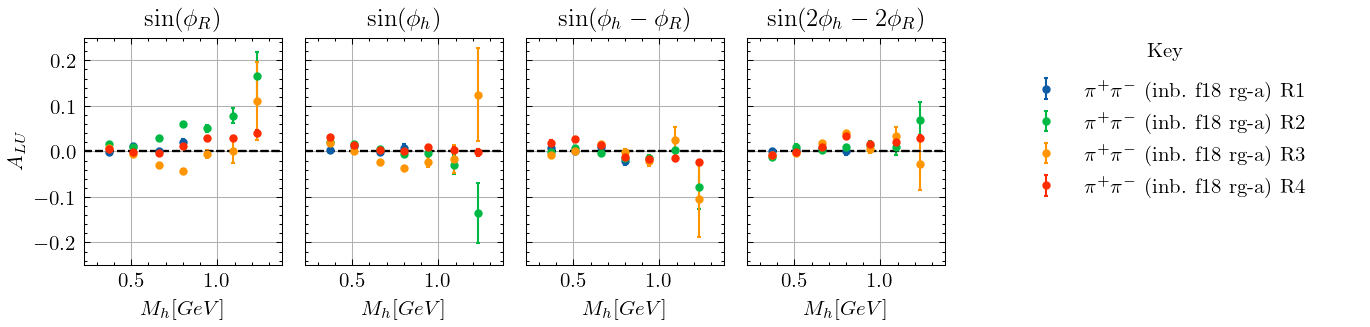

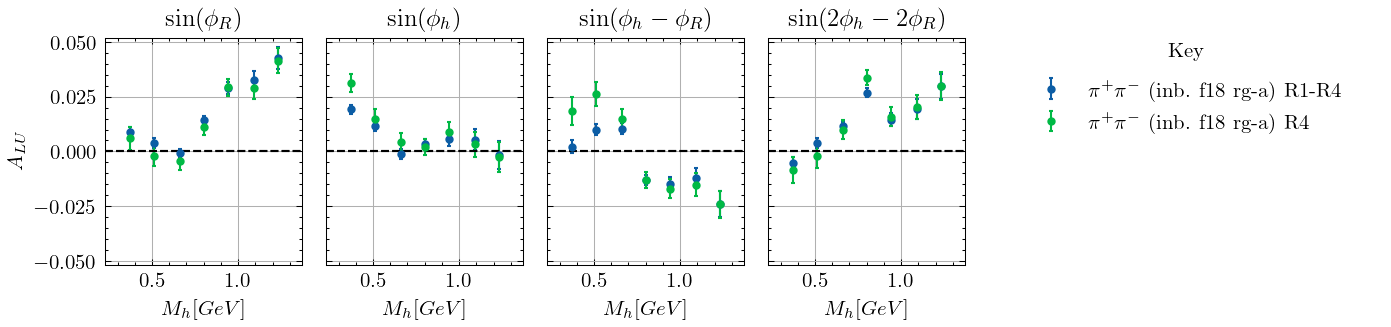

In [18]:
channel="piplus_piminus"
binvar="Mh"
version="Fall2018_RGA_inbending"

plot_channels(data,[
                   [version,"cut_v6_11",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6_12",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6_21",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1","R2","R3","R4"])

plot_channels(data,[
                   [version,"cut_v1",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]
                   ],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1-R4","R4"])

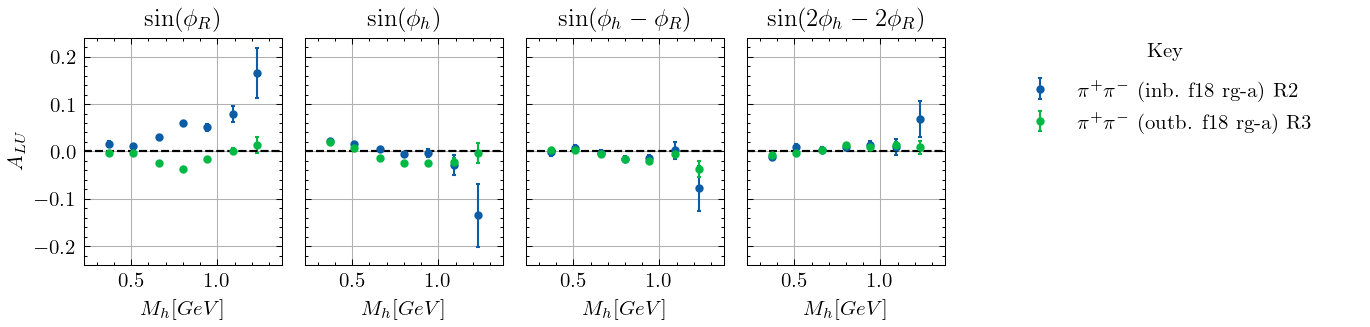

In [24]:
channel="piplus_piminus"
binvar="Mh"

plot_channels(data,[
                   ["Fall2018_RGA_inbending","cut_v6_12",channel,binvar,"noML","AZI","standard"],
                   ["Fall2018_RGA_outbending","cut_v6_21",channel,binvar,"noML","AZI","standard"]
                   ],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R2","R3"])

## Pi+Pi+

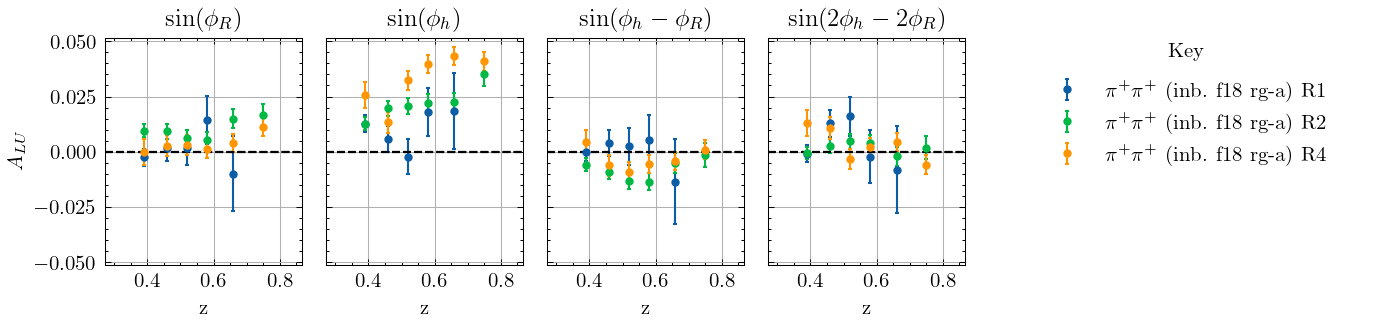

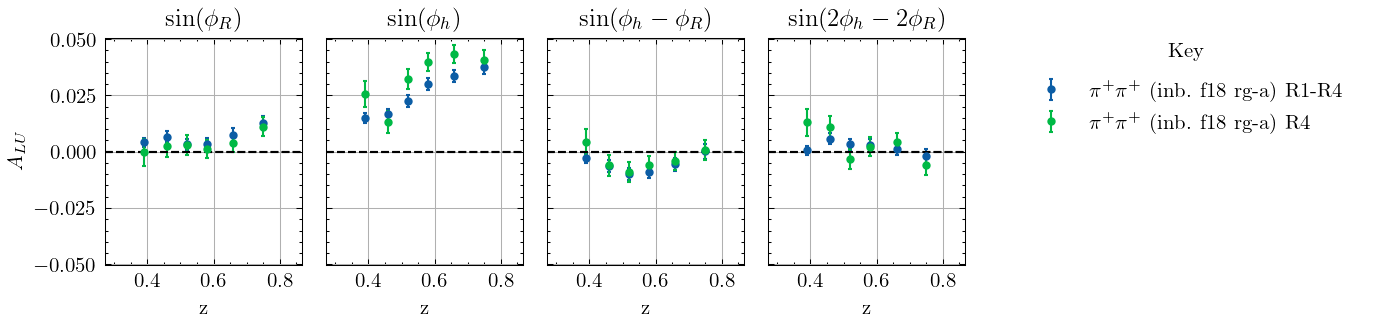

In [16]:
channel="piplus_piplus"
binvar="z"
version="Fall2018_RGA_inbending"

plot_channels(data,[
                   [version,"cut_v6_11",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6_12",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1","R2","R4"])

plot_channels(data,[
                   [version,"cut_v1",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]
                   ],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1-R4","R4"])

## Pi-Pi-

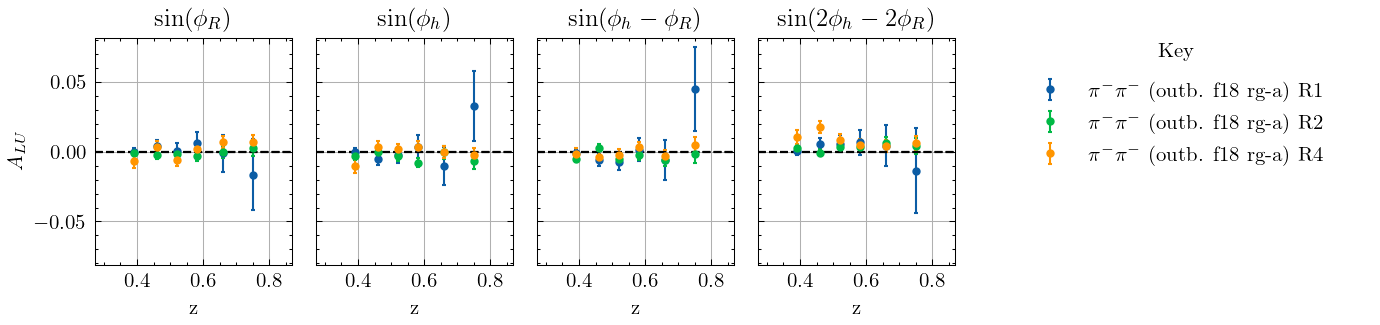

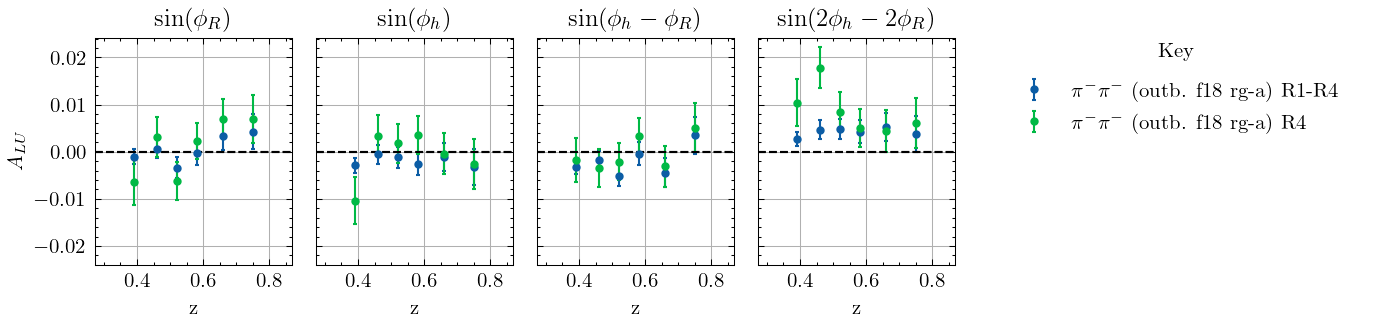

In [17]:
channel="piminus_piminus"
binvar="z"
version="Fall2018_RGA_outbending"

plot_channels(data,[
                   [version,"cut_v6_11",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6_12",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1","R2","R4"])

plot_channels(data,[
                   [version,"cut_v1",channel,binvar,"noML","AZI","standard"],
                   [version,"cut_v6",channel,binvar,"noML","AZI","standard"]
                   ],
             drop_edges=True,
             my_list = [1,2,3,5],
             extra_legends=["R1-R4","R4"])

---
---
---
Extra Code
---

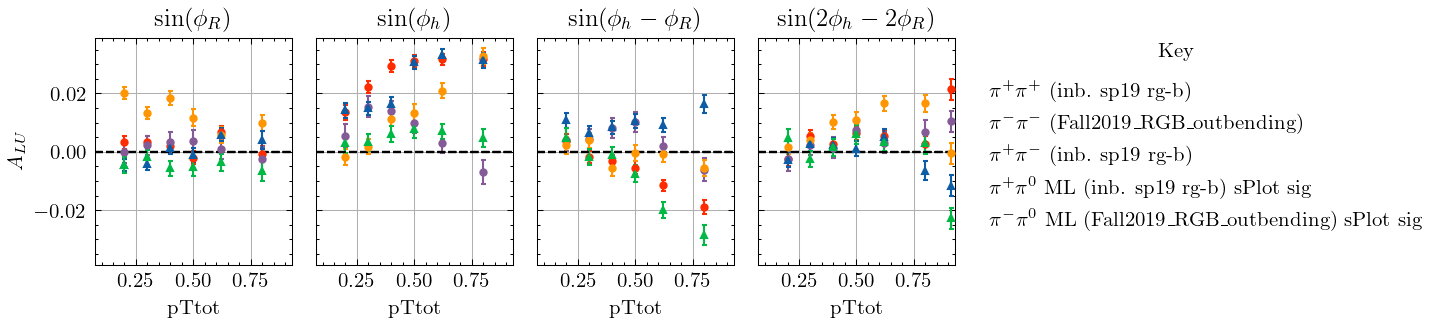

In [9]:
binvar="pTtot"
plot_channels(data,[["Spring2019_RGB_inbending","cut_v6","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2019_RGB_outbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Spring2019_RGB_inbending","cut_v3","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Spring2019_RGB_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2019_RGB_outbending","cut_v7","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5])

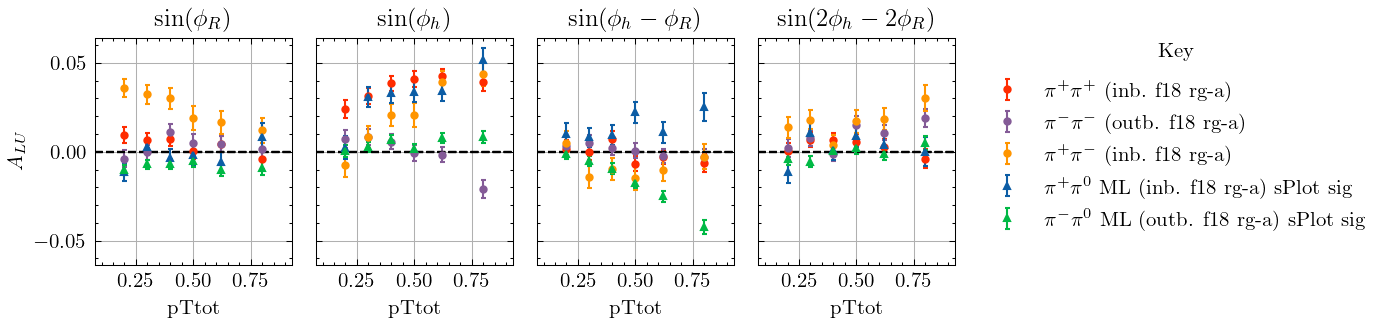

In [17]:
binvar="pTtot"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v6","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v3","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v7","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5])

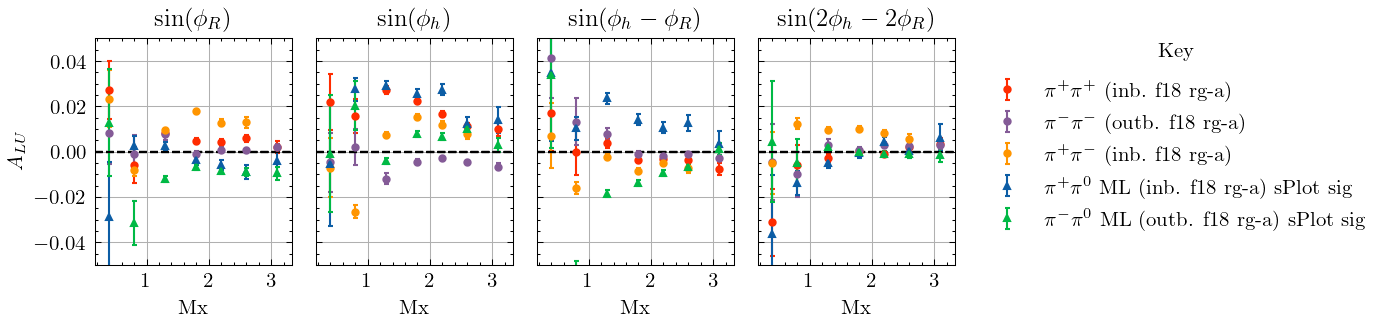

In [11]:
binvar="Mx"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v0","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v0","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v0","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v0","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v0","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5],
             y_lim=[-0.05,0.05])

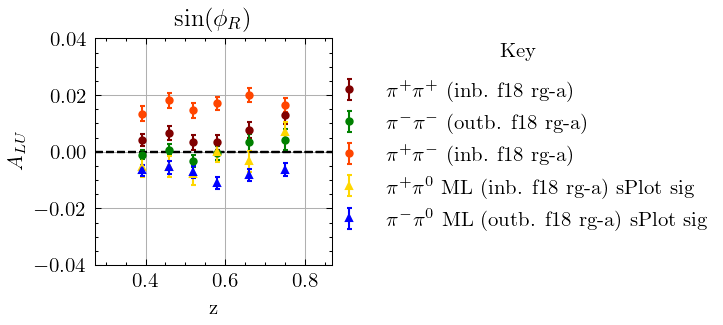

In [28]:
binvar="z"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v1","piplus_piplus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v1","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v1","piplus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_inbending","cut_v1","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v1","piminus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
             drop_edges=True,
             my_list=[1],
             y_lim=[-0.04,0.04])

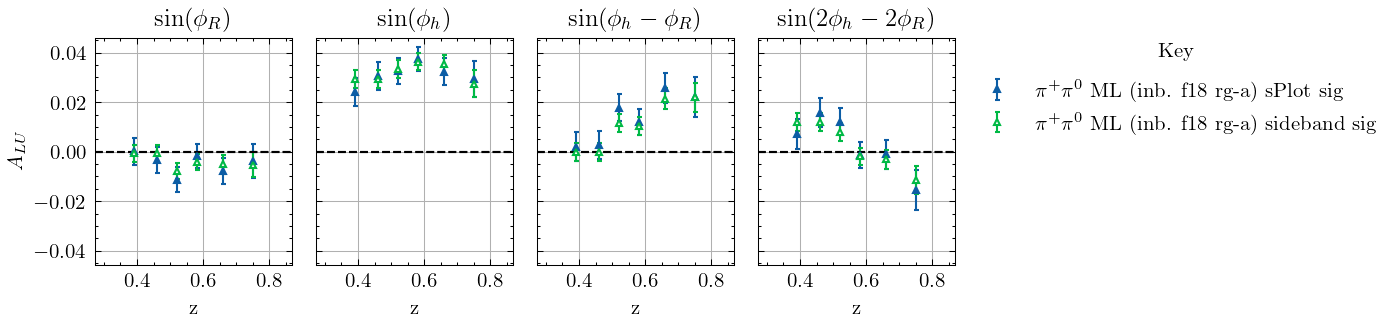

In [25]:
binvar="z"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","sideband"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5])

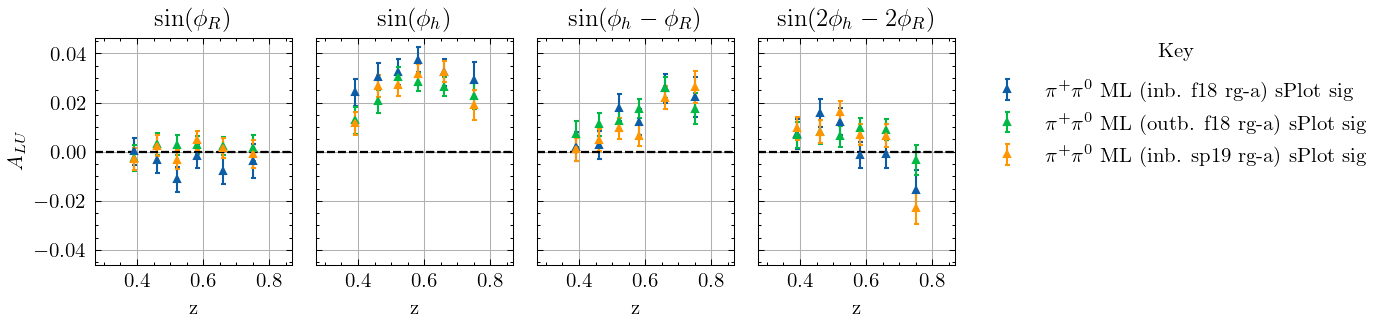

In [20]:
binvar="z"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Fall2018_RGA_outbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"],
                        ["Spring2019_RGA_inbending","cut_v4","piplus_pi0",binvar,"ML","AZI","splot_sig"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5])

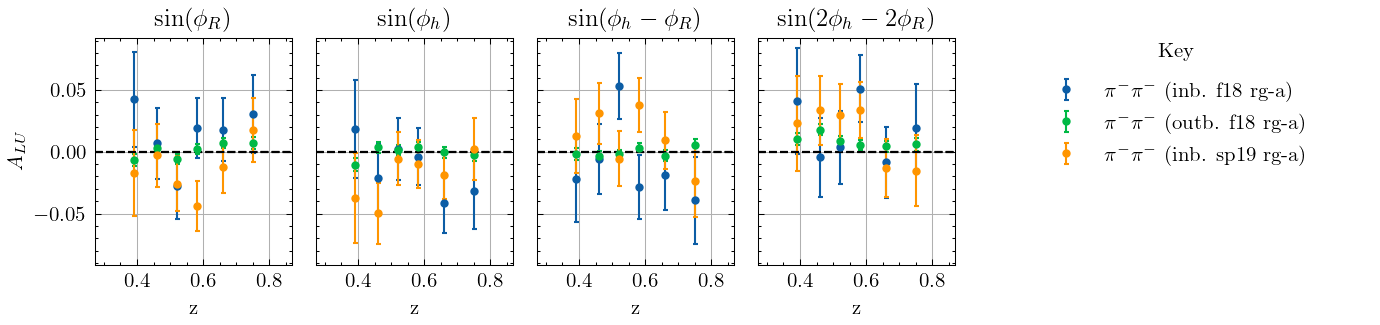

In [22]:
binvar="z"
plot_channels(data,[["Fall2018_RGA_inbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Fall2018_RGA_outbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"],
                        ["Spring2019_RGA_inbending","cut_v6","piminus_piminus",binvar,"noML","AZI","standard"]
                        ],
             drop_edges=True,
             my_list=[1,2,3,5])

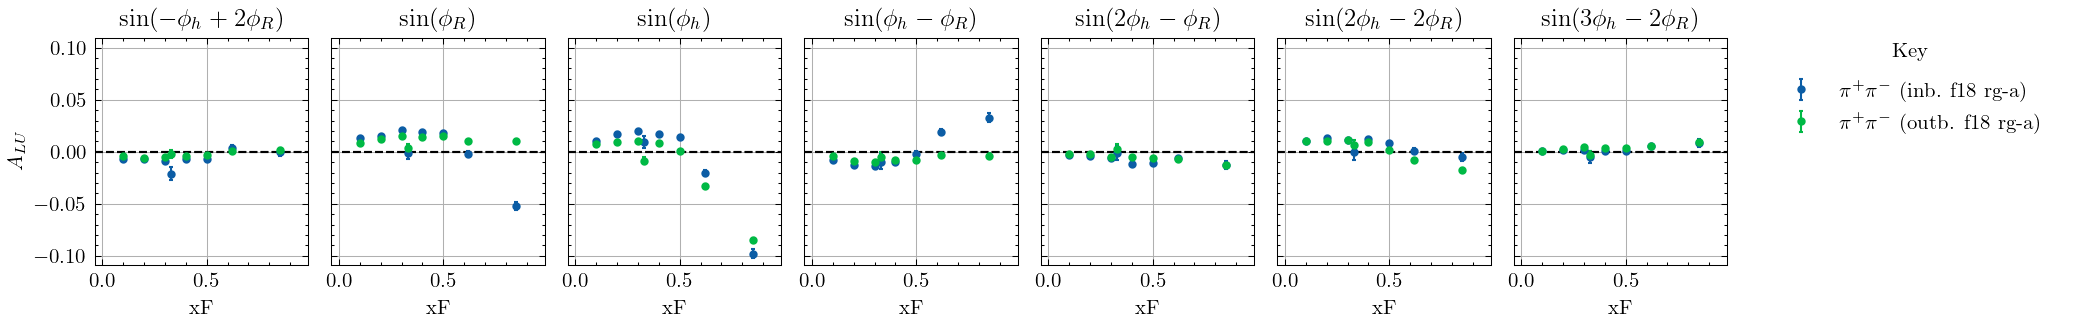

In [13]:
plot_channels(data,[
                    ["Fall2018_RGA_inbending","cut_v0","piplus_piminus","xF","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v0","piplus_piminus","xF","noML","AZI","standard"]
                   ],
             drop_edges=True)

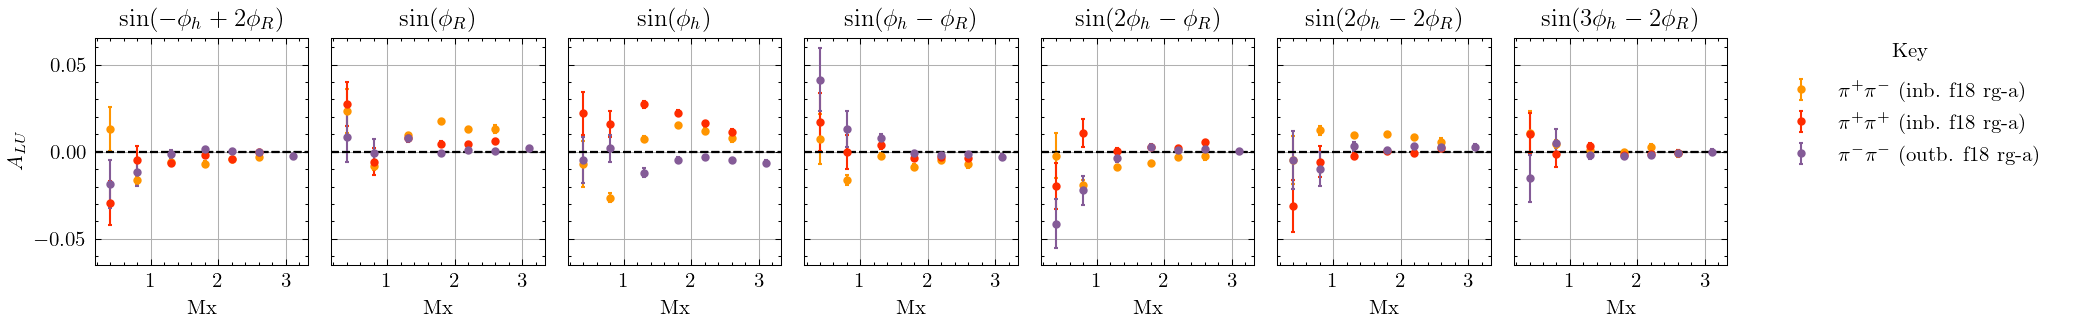

In [16]:
plot_channels(data,[
                    ["Fall2018_RGA_inbending","cut_v0","piplus_piminus","Mx","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v0","piplus_piplus","Mx","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v0","piminus_piminus","Mx","noML","AZI","standard"]
                   ],
             drop_edges=True)

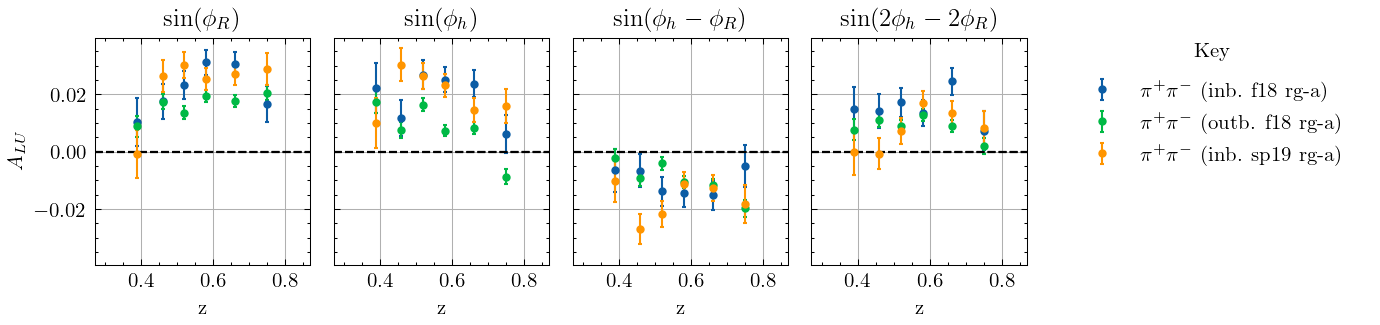

In [9]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v3","piplus_piminus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v3","piplus_piminus","z","noML","AZI","standard"],
                    ["Spring2019_RGA_inbending","cut_v3","piplus_piminus","z","noML","AZI","standard"]
                    ],
             drop_edges=True,
             my_list=[1,2,3,5])

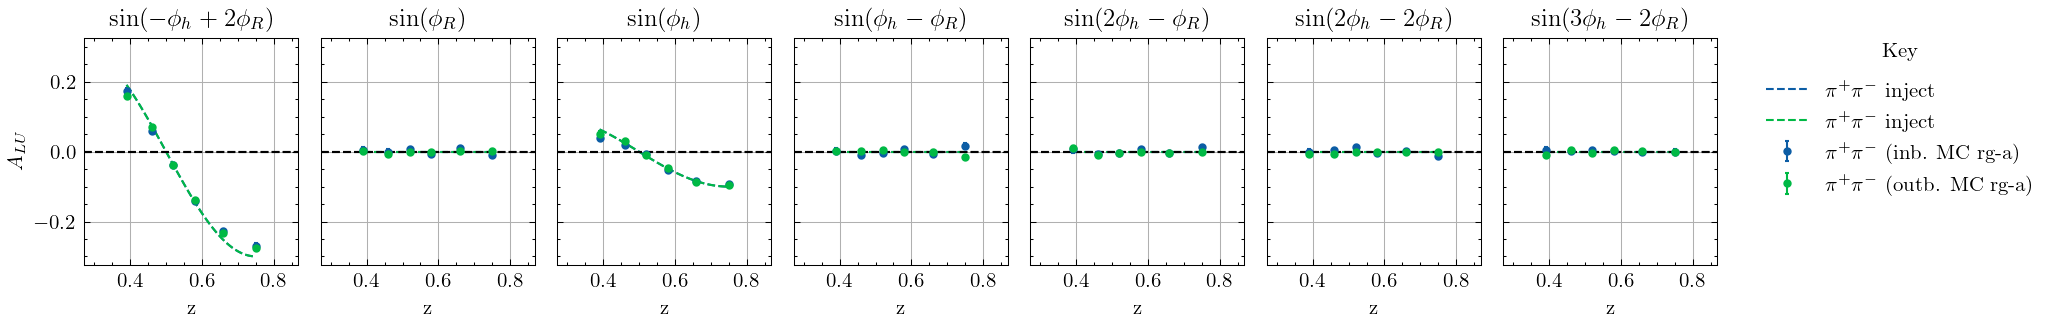

In [204]:
plot_channels(data,[["MC_RGA_inbending","cut_v3","piplus_piminus","z","noML","AZI","standard"],
                    ["MC_RGA_outbending","cut_v3","piplus_piminus","z","noML","AZI","standard"]
                    ],
             drop_edges=True)

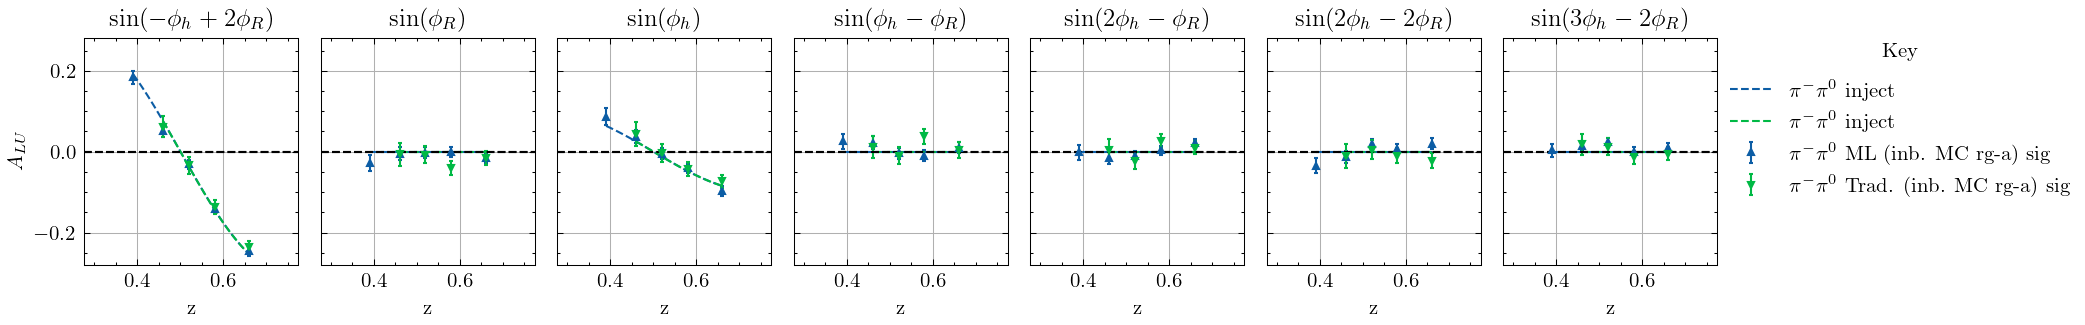

In [205]:
plot_channels(data,[["MC_RGA_inbending","cut_v4","piminus_pi0","z","ML","AZI","splot_sig"],
                    ["MC_RGA_inbending","cut_v4","piminus_pi0","z","noML","AZI","splot_sig"]
                    ],
             drop_edges=True)

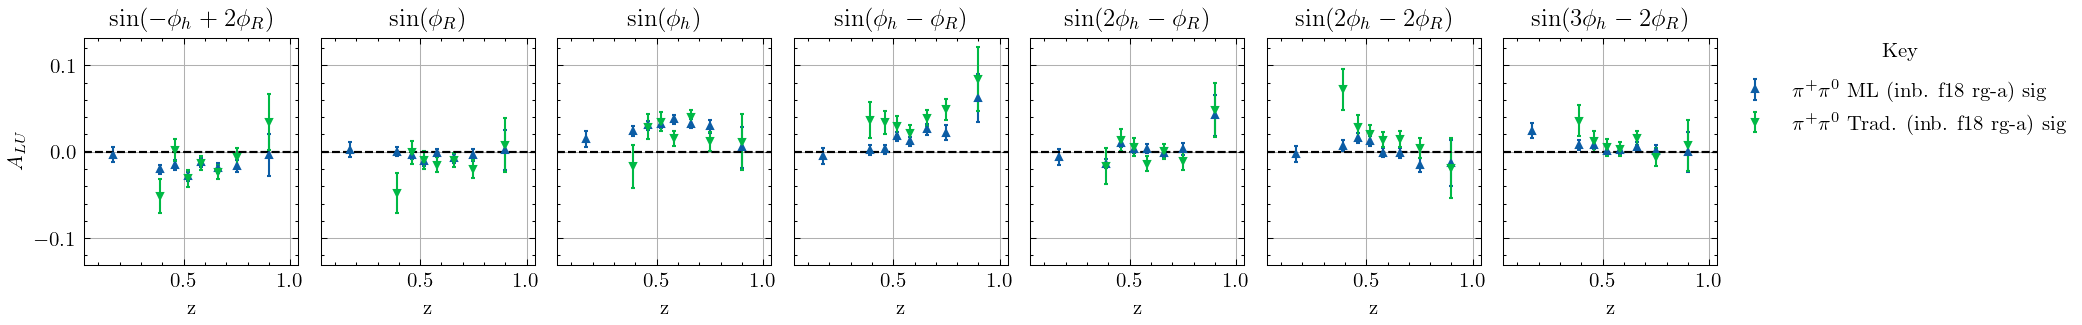

In [206]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v4","piplus_pi0","z","ML","AZI","splot_sig"],
                    ["Fall2018_RGA_inbending","cut_v4","piplus_pi0","z","noML","AZI","splot_sig"]
                    ])

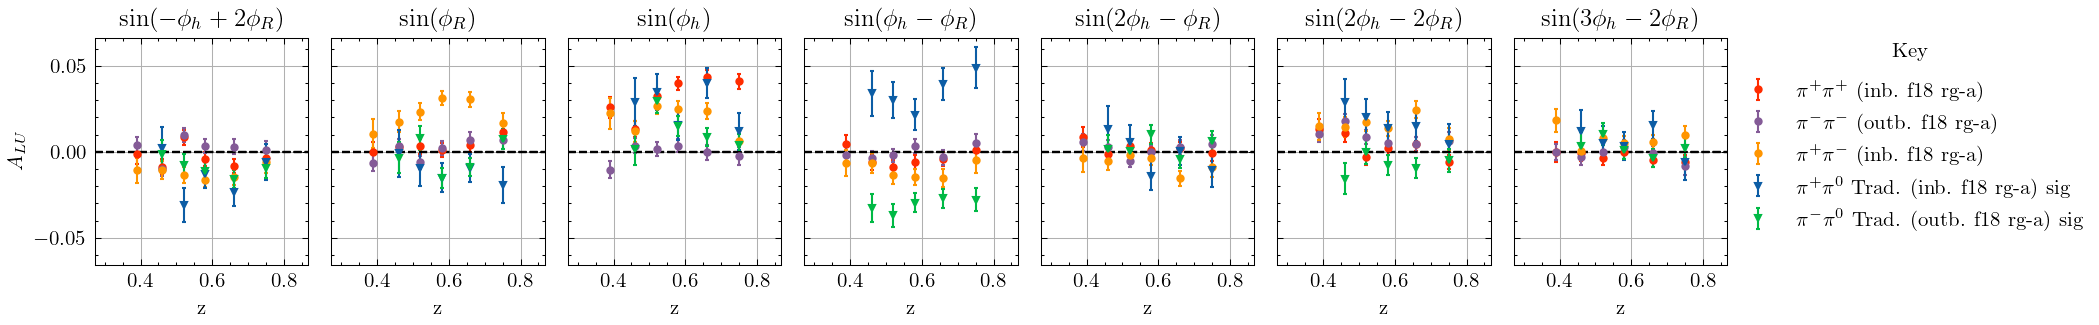

In [207]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v6","piplus_piplus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v6","piminus_piminus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v3","piplus_piminus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v4","piplus_pi0","z","ML","AZI","splot_sig"],
                    ["Fall2018_RGA_outbending","cut_v4","piminus_pi0","z","ML","AZI","splot_sig"]
                    ],
             drop_edges=True)

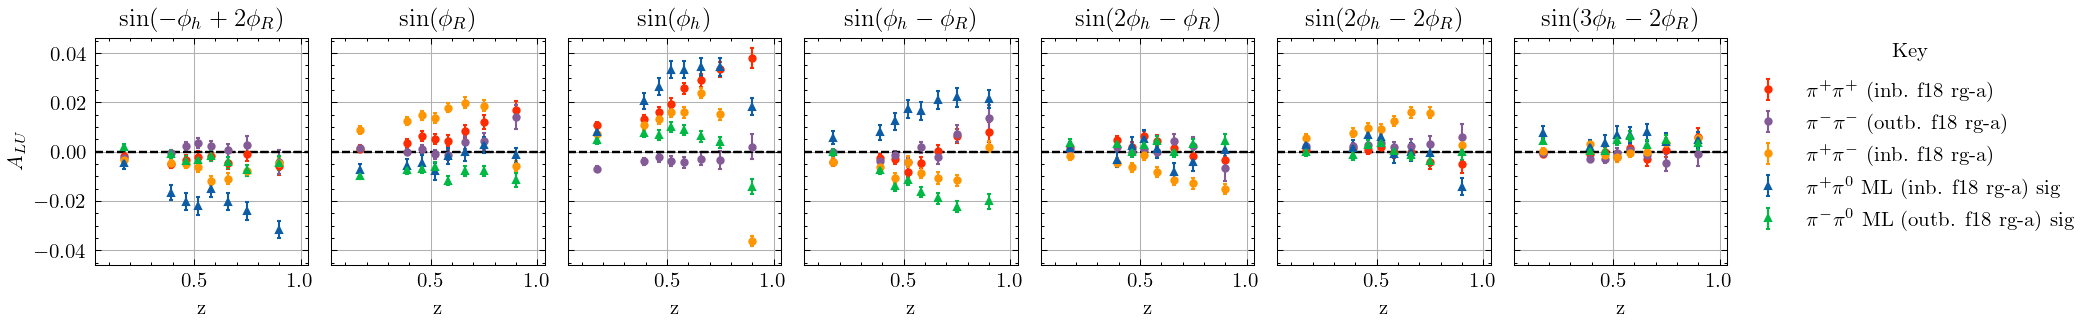

In [12]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v0","piplus_piplus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v0","piminus_piminus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v0","piplus_piminus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v0","piplus_pi0","z","ML","AZI","splot_sig"],
                    ["Fall2018_RGA_outbending","cut_v0","piminus_pi0","z","ML","AZI","splot_sig"]
                    ],
             drop_edges=False)

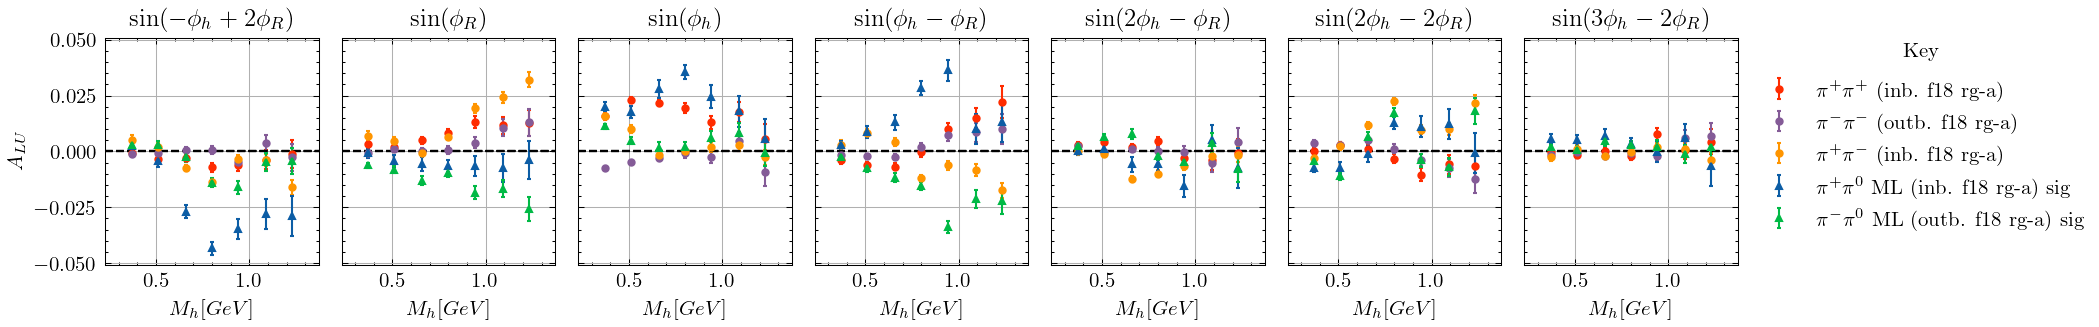

In [9]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v0","piplus_piplus","Mh","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v0","piminus_piminus","Mh","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v0","piplus_piminus","Mh","noML","AZI","standard"],
                    ["Fall2018_RGA_inbending","cut_v0","piplus_pi0","Mh","ML","AZI","splot_sig"],
                    ["Fall2018_RGA_outbending","cut_v0","piminus_pi0","Mh","ML","AZI","splot_sig"]
                    ],
             drop_edges=True)

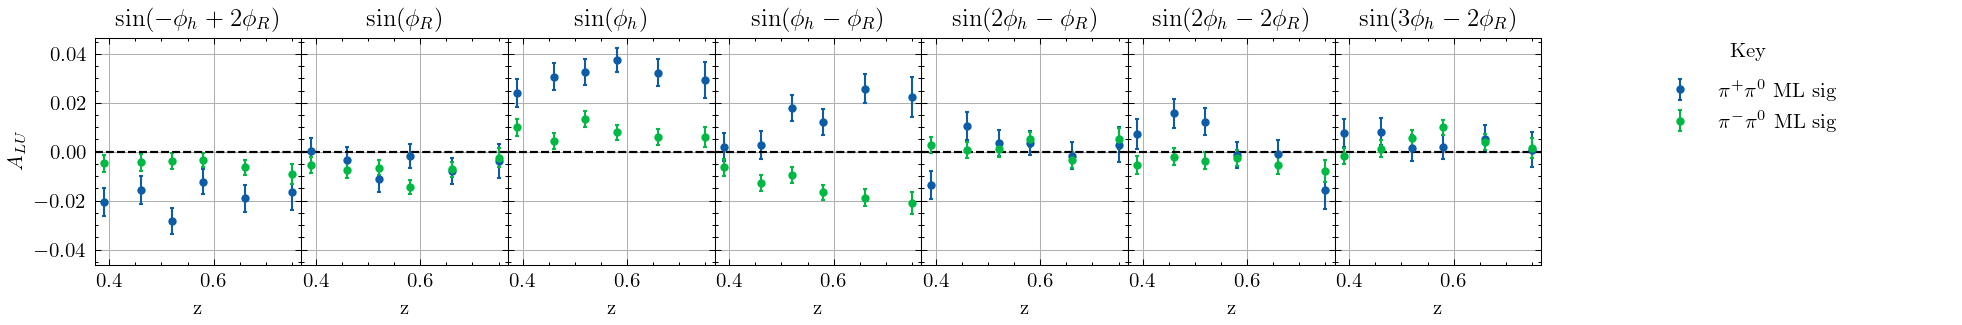

In [126]:
plot_channels(data,[
                    ["Fall2018_RGA_inbending","cut_v4","piplus_pi0","z","ML","AZI","splot_sig"],
                    ["Fall2018_RGA_outbending","cut_v4","piminus_pi0","z","ML","AZI","splot_sig"]
                    ],
             drop_edges=True)

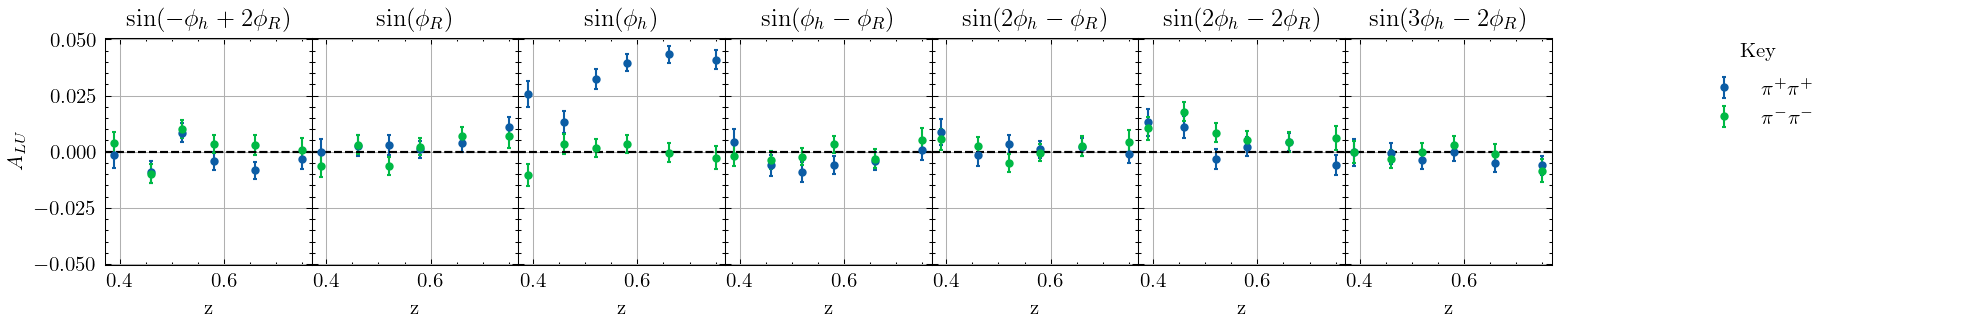

In [125]:
plot_channels(data,[["Fall2018_RGA_inbending","cut_v6","piplus_piplus","z","noML","AZI","standard"],
                    ["Fall2018_RGA_outbending","cut_v6","piminus_piminus","z","noML","AZI","standard"]
                    ],
             drop_edges=True)